# Time Series Analysis:
Original Notebook: https://www.kaggle.com/code/foucardm/tensorflow-certification-time-series/notebook
Focused on time series and forecasting methods using both CNN's and RNN's. This will be discussed:
1. Train, tune and use time series, sequence and prediction models
2. Prepare data for time series learning
3. Use RNN's and CNN's for time series, sequence and forecasting models
4. Using trailing windows vs centered windows
5. Using *Tensorflow* for time series
6. Identify and compensate for sequence bias
7. Adjusting the learning rate dynamically in time series, sequence and prediction models

*I want to forecast temperature for the next hour given the 48 previous hours of features*

## Preparing the data

### Downloading the data

In [3]:
import datetime as dt
# Importing the necessary libraries
import os

import matplotlib as mpl
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
# Setting some configurations on matplotlib
mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams["axes.grid"] = False

In [5]:
# Downloading the dataset:
zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

In [6]:
# Generating the DataFrame:
df = pd.read_csv(csv_path)
df.sample(5)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
22070,03.06.2009 06:30:00,986.41,9.53,283.80,3.63,66.53,11.91,7.92,3.99,5.01,8.03,1211.87,2.70,4.88,287.00
166633,02.03.2012 04:40:00,998.93,7.92,281.17,7.38,96.40,10.68,10.30,0.38,6.44,10.31,1233.22,1.03,1.36,37.57
372439,29.01.2016 19:20:00,996.65,7.74,281.17,0.42,59.69,10.55,6.30,4.25,3.94,6.32,1233.05,7.15,10.09,217.40
304363,14.10.2014 01:20:00,982.32,12.98,287.60,12.14,94.60,14.98,14.17,0.81,9.02,14.42,1189.40,0.68,1.16,179.30
266724,26.01.2014 06:40:00,981.77,-7.87,266.69,-9.07,91.00,3.37,3.07,0.30,1.95,3.13,1287.67,4.05,5.21,8.97


### Data Preprocessing

In [7]:
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess the data
    :param df: DataFrame. The data to be preprocessed
    :return: DataFrame. The preprocessed data
    """
    # Getting rid of the outliers
    df.loc[df["wv (m/s)"] == -9999.0, "wv (m/s)"] = 0.0
    df.loc[df["max. wv (m/s)"] == -9999.0, "max. wv (m/s)"] = 0.0

    # Taking values every hour. REMEMBER THAT DATA WAS COLLECTED EVERY 10 MINUTES
    df = df[::6]  # df[start: stop: step]
    wv = df.pop("wv (m/s)")
    max_wv = df.pop("max. wv (m/s)")

    # Convert degrees to radians. This is done to avoid the model to learn that 0 and 360 are different values
    wd_rad = (df.pop("wd (deg)") % 360) * np.pi / 180  # Wind direction in radians

    # Calculate the wind x and y components
    df["Wx"] = wv * np.cos(wd_rad)
    df["Wy"] = wv * np.sin(wd_rad)

    # Calculate the max wind x and y components
    df["max Wx"] = max_wv * np.cos(wd_rad)
    df["max Wy"] = max_wv * np.sin(wd_rad)

    date_time = pd.to_datetime(df.pop("Date Time"), format="%d.%m.%Y %H:%M:%S")
    # Calculating the timestamp (seconds that have elapsed since the POSIX epoch)
    timestamps = date_time.map(
        dt.datetime.timestamp)  # Returns the time in seconds since the epochs as a float for each element in the series
    # Number of seconds in a day
    day_in_seconds = 24 * 60 * 60
    # Number of seconds in a year
    year_in_seconds = 365 * day_in_seconds
    # Capturing the cyclicality of the time
    df["Day sin"] = np.sin(timestamps * (2 * np.pi / day_in_seconds))
    df["Day cos"] = np.cos(timestamps * (2 * np.pi / day_in_seconds))
    df["Year sin"] = np.sin(timestamps * (2 * np.pi / year_in_seconds))
    df["Year cos"] = np.cos(timestamps * (2 * np.pi / year_in_seconds))
    return df

In [8]:
# Splitting the data into train, validation and test sets
from typing import Tuple


def split_data(df: pd.DataFrame, train_fraction: float = 0.7, val_fraction: float = 0.20) -> Tuple[
    pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splitting the data into train, validation and test sets
    :param df: pd.DataFrame. The data to be split
    :param train_fraction: float. The fraction of the data to be used for training
    :param val_fraction: float. The fraction of the data to be used for validation
    :return: Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]. The split data
    """
    rows = df.shape[0]
    last_train_row = int(rows * train_fraction)
    last_val_row = int(rows * (train_fraction + val_fraction))

    train_df = df[0: last_train_row]
    val_df = df[last_train_row: last_val_row]
    test_df = df[last_val_row:]

    return train_df, val_df, test_df

In [9]:
# Standardize a DataFrame using StandardScaler
from sklearn.preprocessing import StandardScaler


def standardize(df: pd.DataFrame) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Standardize a DataFrame using StandardScaler
    :param df: pd.DataFrame. The data to be standardized
    :return: Tuple[pd.DataFrame, StandardScaler]. The standardized data and the scaler used
    """
    scaler = StandardScaler().fit(df)
    df_standardized = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
    return df_standardized, scaler

In [10]:
# Getting the preprocessed data
df_preprocessed = preprocessing(df)

# Splitting the data
train_df, val_df, test_df = split_data(df_preprocessed)

# Standardizing the data:
train_df_standardized, train_scaler = standardize(train_df)
val_df_standardized, val_scaler = standardize(val_df)
test_df_standardized, test_scaler = standardize(test_df)

C:\Users\valve\AppData\Local\Temp\ipykernel_17060\3851980650.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Wx"] = wv * np.cos(wd_rad)
C:\Users\valve\AppData\Local\Temp\ipykernel_17060\3851980650.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Wy"] = wv * np.sin(wd_rad)
C:\Users\valve\AppData\Local\Temp\ipykernel_17060\3851980650.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [11]:
train_df_standardized.sample()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
64128,0.988749,-0.424966,-0.499131,-0.014065,1.075022,-0.566002,-0.220062,-0.711794,-0.236947,-0.236012,0.623188,-0.192615,0.840577,-0.176227,0.811408,-0.860813,-1.122097,1.354444,0.051252


## Forecasting temperature
Finding the temperature of the next hour given the previous 48 hours of data

In [12]:
n_steps = 48  # Remember that the data is organized in hours. Looking at all the features from the last 2 days
n_horizon = 24  # Trying to predict the temperature of the  next day same hour
window_length = n_steps + n_horizon
batch_size = 32

In [13]:
# Creating the windowed dataset
def create_dataset(X: pd.DataFrame, y: pd.Series, n_steps: int = 48, n_horizon: int = 24) -> Tuple[np.ndarray, np.ndarray]:
    """
    Creating the windowed dataset
    :param X: pd.DataFrame. The features
    :param y: pd.Series. The labels'
    :param n_horizon: int. The number of steps to predict
    :param n_steps: int. The number of steps to look back
    :return: Tuple[np.ndarray, np.ndarray]. The windowed dataset 
    """
    Xs, ys = [], []
    for i in range(0, (len(X) - n_steps - n_horizon)):
        Xs.append(X.iloc[i: i + n_steps].to_numpy())
        ys.append(y.iloc[(i + n_horizon)])
    return np.array(Xs), np.array(ys)

In [14]:
#Generating the training data
X_train, y_train = create_dataset(X=train_df_standardized,
                                  y=train_df_standardized["T (degC)"],
                                  n_steps=n_steps,
                                  n_horizon=n_horizon)

# Generating the validation data
X_val, y_val = create_dataset(X=val_df_standardized,
                              y=val_df_standardized["T (degC)"],
                              n_steps=n_steps,
                              n_horizon=n_horizon)

In [15]:
# Viewing the shape of the data
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (48992, 48, 19)
y_train shape: (48992,)
X_val shape: (13946, 48, 19)
y_val shape: (13946,)


### Baseline model
The baseline model will just output the last temperature of the previous day at the given hour. This is a standard practice apparently in time series forecasting where I just take the previous information and use it to predict the next value. This is called the **naive evaluation**

In [16]:
def naive_model_mae(y: np.array, n_steps: int = 48, n_horizon: int = 24):
    """
    Naive model. It just outputs the last temperature of the previous day at the given hour 
    :param y: np.array. The labels
    :param n_steps: Int. The number of steps to look back
    :param n_horizon: Int. The number of steps to predict
    :return: 
    """
    # Generating the naive predictions
    abs_errors = []
    for i in range(n_steps + n_horizon, len(y)):
        prediction = y[i - n_horizon]
        actual = y[i]
        abs_errors.append(np.abs(prediction - actual))
    return np.mean(abs_errors)

In [17]:
naive_model_mae = naive_model_mae(y=y_val)

### Dense model
Having just a Flatten layer and a Dense layer

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [19]:
dense_model = Sequential([
    Flatten(input_shape=(n_steps, X_train.shape[2])),
    Dense(32, activation="relu"),
    Dense(1)  # Because I need only one output
])

# Compiling the model where I define the loss function and the optimizer
dense_model.compile(optimizer="Adam", loss="mae", metrics=["mae"])
dense_history = dense_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32)  # Where the batch size indicates the number of samples it will process before updating the model's weights and biases

Epoch 1/30
1531/1531 [==============================] - 4s 2ms/step - loss: 0.1915 - mae: 0.1915 - val_loss: 0.0742 - val_mae: 0.0742
Epoch 2/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.0577 - mae: 0.0577 - val_loss: 0.0439 - val_mae: 0.0439
Epoch 3/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.0373 - mae: 0.0373 - val_loss: 0.0412 - val_mae: 0.0412
Epoch 4/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.0335 - mae: 0.0335 - val_loss: 0.0457 - val_mae: 0.0457
Epoch 5/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.0294 - mae: 0.0294 - val_loss: 0.0329 - val_mae: 0.0329
Epoch 6/30
1531/1531 [==============================] - 4s 2ms/step - loss: 0.0263 - mae: 0.0263 - val_loss: 0.0410 - val_mae: 0.0410
Epoch 7/30
1531/1531 [==============================] - 3s 2ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0287 - val_mae: 0.0287
Epoch 8/30
1531/1531 [==============================] - 3s 2ms

In [20]:
# Defining a function to plot the loss and the metrics

from keras.callbacks import History
import matplotlib.pyplot as plt


def plot(history: History, naive_loss: int) -> None:
    """
    Plotting the loss and the metrics
    :param history: History. The history of the model
    :param naive_loss: Int. Baseline loss
    :return: None
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))  # Getting the number of epochs the model was trained on
    plt.figure()  # Creating a new figure
    plt.plot(epochs, loss, "b", label="Training Loss")
    plt.plot(epochs, val_loss, "g", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.axhline(y=naive_loss, color="r")
    plt.legend()
    plt.show()
    return None

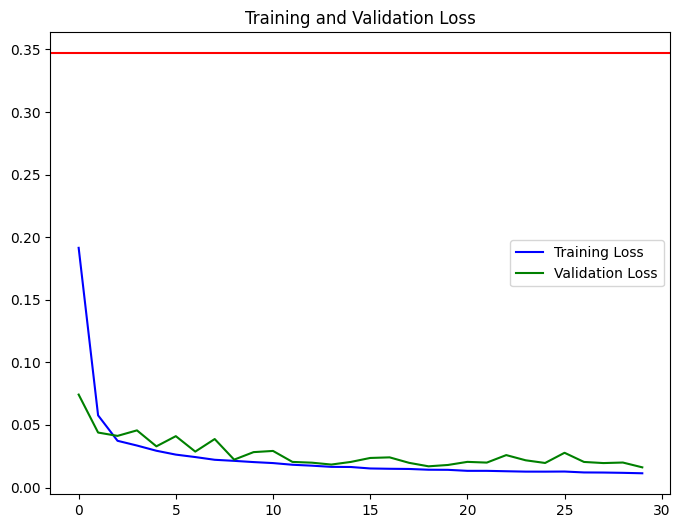

In [21]:
plot(history=dense_history, naive_loss=naive_model_mae)

*Note*: It is extremely interesting to notice that the model is much better than the model used by the original author. My intuition is perhaps in differences in the windowing of the data and / or the preprocessing of the time cycle using the sine and cosine functions which are a bit different. Other than that, further analysis needs to be done 

### Iterator
I am going to generate an iterator right from the training DataFrame, where before I build the data generating the windows manually where the size was (48, 19).
In this scenario, I am going to play a bit with `tf.data.Dataset.from_tensor_slices`  and ` tf.data.Dataset.window` to generate the windows

In [22]:
train_df_standardized

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
0,0.947770,-1.978961,-2.039545,-1.935844,1.050866,-1.302887,-1.484080,-0.784450,-1.487116,-1.489345,2.215771,-0.159551,0.560321,-0.190746,0.584291,1.412882,-0.061770,0.180520,1.422373
6,0.945360,-1.932745,-1.992554,-1.849794,1.141453,-1.288591,-1.448440,-0.792753,-1.449686,-1.454139,2.165232,0.207054,0.280085,0.109480,0.329520,1.348777,-0.425360,0.181526,1.422195
12,0.961028,-2.074858,-2.134675,-2.050577,1.062944,-1.330179,-1.529223,-0.788601,-1.532032,-1.533939,2.322219,0.220170,0.291082,0.156918,0.343973,1.192759,-0.759967,0.182531,1.422016
18,0.989954,-2.073702,-2.135821,-2.049142,1.062944,-1.328879,-1.529223,-0.788601,-1.528289,-1.533939,2.328567,0.272069,0.287880,0.255051,0.347255,0.955462,-1.042790,0.183537,1.421837
24,1.011648,-2.118763,-2.182813,-2.129456,0.984435,-1.341875,-1.560111,-0.780298,-1.561976,-1.564451,2.383501,0.248644,0.227130,0.194460,0.214437,0.653056,-1.254554,0.184542,1.421657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294354,0.181232,0.909506,0.889993,1.560646,0.905926,0.783004,1.963457,-0.464764,1.956464,1.953799,-0.882477,-0.355845,-1.536429,-0.216219,-1.056133,1.083378,0.908995,-1.059431,-0.977262
294360,0.271626,0.841338,0.815493,1.433006,0.797221,0.690731,1.728236,-0.408715,1.720653,1.719092,-0.790677,-0.319853,-0.813127,-0.542552,-1.089441,1.281733,0.597616,-1.060165,-0.976559
294366,0.187259,0.729266,0.710048,1.414361,1.093140,0.545173,1.694972,-0.612152,1.690709,1.688580,-0.712550,-0.104067,0.764897,-0.093722,0.748247,1.392744,0.245505,-1.060899,-0.975856
294372,0.200516,0.715401,0.695149,1.427269,1.171649,0.526978,1.718732,-0.659897,1.713167,1.712051,-0.698389,0.620469,-0.444602,0.653410,-0.414155,1.408847,-0.123342,-1.061632,-0.975153


In [23]:
# Creating the iterator right from the training DataFrame
train_ds = tf.data.Dataset.from_tensor_slices(train_df_standardized)
train_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(19,), dtype=tf.float64, name=None)>

Making the data ready to be fed into my model

In [24]:
# Generating the windows
def deep_copy(element):
    return element
train_ds_copy = train_ds.map(deep_copy)
train_ds_copy = train_ds_copy.window(window_length, shift=1, drop_remainder=True)
train_ds_copy
# train_ds_copy = train_ds_copy.flat_map(lambda window: window.batch(window_length))
# train_ds

<_WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(19,), dtype=tf.float64, name=None), TensorShape([]))>

In [25]:
for element in train_ds_copy.take(1):
    print(len(element))

72


In [26]:
train_ds_copy = train_ds_copy.flat_map(lambda window: window.batch(window_length))
for element in train_ds_copy.take(1):
    print(element.shape)
    print(len(element))

(72, 19)
72


I can see no visible difference when applying the `flat_map` and not applying the `flat_map`

In [27]:
train_ds = train_ds.window(size=window_length, shift=1, drop_remainder=True)

In [28]:
val_ds = tf.data.Dataset.from_tensor_slices(val_df_standardized)

In [29]:
df.shape[0]

420551

In [30]:
df.shape

(420551, 15)

In [31]:
test_ds = tf.data.Dataset.from_tensor_slices(test_df_standardized)

In [32]:
# Now I have to make the adequate windows for the train, validation and test sets
train_ds = train_ds.flat_map(lambda window: window.batch(window_length))
train_ds = train_ds.map(lambda window: (window[:48,:], window[-1,1]))

In [33]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [34]:
# Now for the validation set:
# Windowing the dataset:
val_ds = val_ds.window(size=window_length, shift=1, drop_remainder=True)
val_ds = val_ds.flat_map(lambda window: window.batch(window_length))
val_ds = val_ds.map(lambda window: (window[:48,:], window[-1, 1]))

In [35]:
for element in val_ds.take(1):
    print(element)

(<tf.Tensor: shape=(48, 19), dtype=float64, numpy=
array([[ 2.56898884e-02,  6.36997474e-01,  6.29227176e-01,
         1.39472577e+00,  1.16072906e+00,  3.98354656e-01,
         1.49909993e+00, -6.36055575e-01,  1.49241200e+00,
         1.49381182e+00, -6.61989918e-01,  1.24875764e-01,
         6.55438237e-02,  6.58442084e-02,  3.40033835e-02,
         1.15965221e+00, -8.11110810e-01, -8.57307892e-01,
        -1.30997256e+00],
       [ 5.11738532e-02,  5.71639782e-01,  5.61978316e-01,
         1.35993330e+00,  1.27383357e+00,  3.29348883e-01,
         1.44469013e+00, -7.00714644e-01,  1.43788047e+00,
         1.44005662e+00, -5.94856495e-01,  1.07276665e-01,
        -1.85035941e-01,  1.52506848e-01, -8.16257738e-02,
         9.10234594e-01, -1.08330117e+00, -8.58027839e-01,
        -1.30923084e+00],
       [ 8.01329041e-02,  5.29810859e-01,  5.18007908e-01,
         1.34005189e+00,  1.35552017e+00,  2.86883792e-01,
         1.41501206e+00, -7.44515949e-01,  1.41061470e+00,
         1.4

In [36]:
val_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 19), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [37]:
# Evaluating the naive model
from typing import Iterator


def naive_eval(example):
    batch_maes = []
    for tup in example:
        train, label = tup[0], tup[1]
        predictions = train[-1, 1]
        mae = np.abs(predictions - label)
        batch_maes.append(mae)
    return np.mean(batch_maes)

In [38]:
naive_loss = round(naive_eval(val_ds), 2)

In [39]:
naive_eval(val_ds)

0.34680139928041426

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential([
    Flatten(input_shape=(n_steps, X_train.shape[2])),
    Dense(32, activation="relu"),
    Dense(1)
])

In [41]:
X_train.shape

(48992, 48, 19)

In [86]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle == True: # pay attention ! We are not shuffeling timesteps but elemnts within a batch ! It is important to keep the data in time order
            rows = np.random.randint(min_index + lookback, max_index-delay-1, size=batch_size) # return an array containing size elements ranging from min_index+lookback to max_index
        else:
            if i + batch_size >= max_index-delay-1: #Since we are incrementing on "i". If its value is greater than the max_index --> start from the begining
                i = min_index + lookback # We need to start from the indice lookback, since we want to take lookback elements here.
            rows = np.arange(i, min(i + batch_size, max_index)) # Just creating an array that contain the indices of each sample in the batch
            i+=len(rows) # rows represents the number of sample in one batch
            
        samples = np.zeros((len(rows), lookback//step, data.shape[-1])) # shape = (batch_size, lookback, nbr_of_features)
        targets = np.zeros((len(rows),delay)) #Shape = (batch_size,delay)
        
        for j, row in enumerate(rows): # We loop here for batch_size ie 32 loops
            indice_samples = range(rows[j] - lookback, rows[j], step) #From one indice given by rows[j], we are picking loockback previous elements in the dataset
            indice_targets = range(rows[j], rows[j]+delay, step)
            samples[j] = data[indice_samples]
            targets[j] = data[:,1][indice_targets] #We only want to predict the temperature for now,since [1], the second column
        yield samples, targets # The yield that replace the return to create a generator and not a regular function.

In [87]:
train_gen = generator(data=train_df_standardized.to_numpy(), lookback=n_steps, delay=n_horizon, min_index=0, max_index=len(train_df_standardized.to_numpy()), batch_size=batch_size)

In [88]:
model.compile(optimizer="Adam", loss="mae")
# Remember that I use a `fit_generator` when data might not fit entirely into memory 
history_generator = model.fit(train_gen, epochs=30, steps_per_epoch=train_df_standardized.to_numpy()//batch_size)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [74]:
train_df_standardized.shape[0] // batch_size

1533

### Building a Powerful model

In [89]:
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN


model_LSTM = Sequential([
    LSTM(30, return_sequences=True, input_shape=(None, 19), dropout=0.2, recurrent_dropout=0.2),
    LSTM(30, dropout=0.2, recurrent_dropout=0.2),
    Dense(n_horizon)
])

In [91]:
model_LSTM.compile(optimizer="Adam", loss="mae")
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
1531/1531 [==============================] - 81s 47ms/step - loss: 0.1977 - val_loss: 0.1399
Epoch 2/30
1531/1531 [==============================] - 61s 40ms/step - loss: 0.1310 - val_loss: 0.1264
Epoch 3/30
1531/1531 [==============================] - 59s 39ms/step - loss: 0.1187 - val_loss: 0.1109
Epoch 4/30
1531/1531 [==============================] - 60s 39ms/step - loss: 0.1096 - val_loss: 0.1066
Epoch 5/30
1531/1531 [==============================] - 53s 34ms/step - loss: 0.1034 - val_loss: 0.0994
Epoch 6/30
1531/1531 [==============================] - 53s 35ms/step - loss: 0.0989 - val_loss: 0.1008
Epoch 7/30
1531/1531 [==============================] - 53s 35ms/step - loss: 0.0960 - val_loss: 0.0910
Epoch 8/30
1531/1531 [==============================] - 53s 35ms/step - loss: 0.0929 - val_loss: 0.0960
Epoch 9/30
1531/1531 [==============================] - 62s 41ms/step - loss: 0.0905 - val_loss: 0.0873
Epoch 10/30
1531/1531 [==============================] - 67s 44m

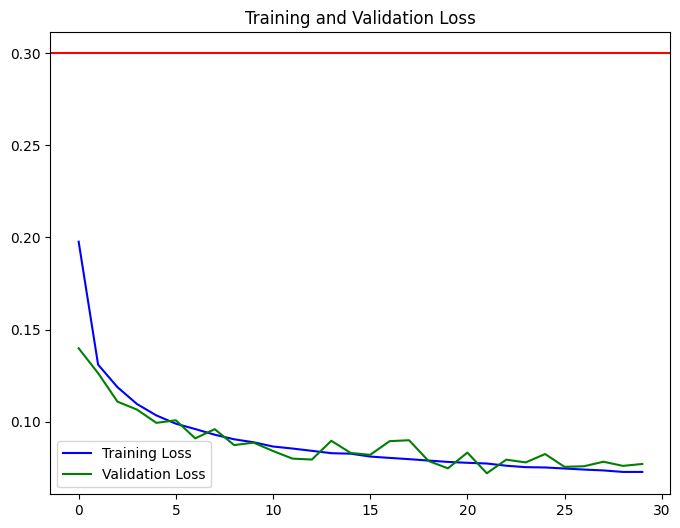

In [92]:
plot(history_LSTM, naive_loss=0.3)